# ripple match verification

In [1]:
import psutil # CIT hack
p = psutil.Process()
p.cpu_affinity([0])

import os
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

# ripple test notebook implementing the random match
import sys
sys.path.append('../../ripple/test/')
from benchmark_waveform import random_match

%load_ext autoreload
%autoreload 2

# from utils_pp_plot import matplotlib_params
mpl_params = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Times New Roman"],
        "xtick.labelsize": 36,
        "ytick.labelsize": 36,
        "axes.labelsize": 36,
        "legend.fontsize": 36,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(mpl_params)
public_html = "/home/urash/twouters/public_html/TurboPE-BNS/figures/"

plt.rcParams['axes.formatter.useoffset'] = False

[CpuDevice(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preamble

Toggle this to true in case we want to rerun things

In [2]:
RUN_BENCHMARK_WAVEFORM = False

## Run the ripple match verification

In [3]:
N_samples = 10_000
bounds = {"m": [0.5, 3.0],
          "chi": [-0.05, 0.05],
          "lambda": [0, 5000],
          "d_L": [1, 400]
        }

outdir = "../data/"

approximant_list = ["IMRPhenomD", "TaylorF2", "IMRPhenomD_NRTidalv2"]
if RUN_BENCHMARK_WAVEFORM:
  for approximant in approximant_list:
      print(f"Checking {approximant}")
      random_match(N_samples, bounds, approximant, outdir, "../data/psds/psd.txt")

## Read in mismatch data

In [4]:
# Choose tidal waveform here
approximant_names = ["IMRPhenomD",
                     "IMRPhenomD_NRTidalv2", 
                     "TaylorF2"]

approximant_names_latex = [r"\texttt{IMRPhenomD}",
                           r"\texttt{IMRPhenomD\_NRTidalv2}", 
                           r"\texttt{TaylorF2}"]

approximant_names_latex = [r"\texttt{IMRD}",
                           r"\texttt{IMRD\_NRTv2}", 
                           r"\texttt{TF2}"]

matches_dict = {}
for approximant in approximant_names:

    matches_filename = os.path.join(os.getcwd(), f"../data/matches_data/matches_{approximant}.csv")
    print(f"Reading in matches from {matches_filename}")
    matches_df = pd.read_csv(matches_filename)

    ### Get the values
    m1_values = matches_df["m1"].values
    m2_values = matches_df["m2"].values
    q_values = matches_df["m2"] / matches_df["m1"].values
    chi1_values = matches_df["chi1"].values
    chi2_values = matches_df["chi2"].values
    mismatch_values = matches_df["mismatch"].values
    if approximant != "IMRPhenomD":
        lambda1_values = matches_df["lambda1"].values
        lambda2_values = matches_df["lambda2"].values
    else:
        lambda1_values = np.zeros(len(m1_values))
        lambda2_values = np.zeros(len(m1_values))

    # Add matches to dictionary
    matches_dict[approximant] = {} 
    matches_dict[approximant]["m1"] = m1_values
    matches_dict[approximant]["m2"] = m2_values
    matches_dict[approximant]["q"] = q_values
    matches_dict[approximant]["chi1"] = chi1_values
    matches_dict[approximant]["chi2"] = chi2_values
    matches_dict[approximant]["mismatch"] = mismatch_values
    matches_dict[approximant]["lambda1"] = lambda1_values
    matches_dict[approximant]["lambda2"] = lambda2_values

Reading in matches from /home/thibeau.wouters/TurboPE-BNS/postprocessing/../data/matches_data/matches_IMRPhenomD.csv
Reading in matches from /home/thibeau.wouters/TurboPE-BNS/postprocessing/../data/matches_data/matches_IMRPhenomD_NRTidalv2.csv
Reading in matches from /home/thibeau.wouters/TurboPE-BNS/postprocessing/../data/matches_data/matches_TaylorF2.csv


## Plot the mismatch histograms

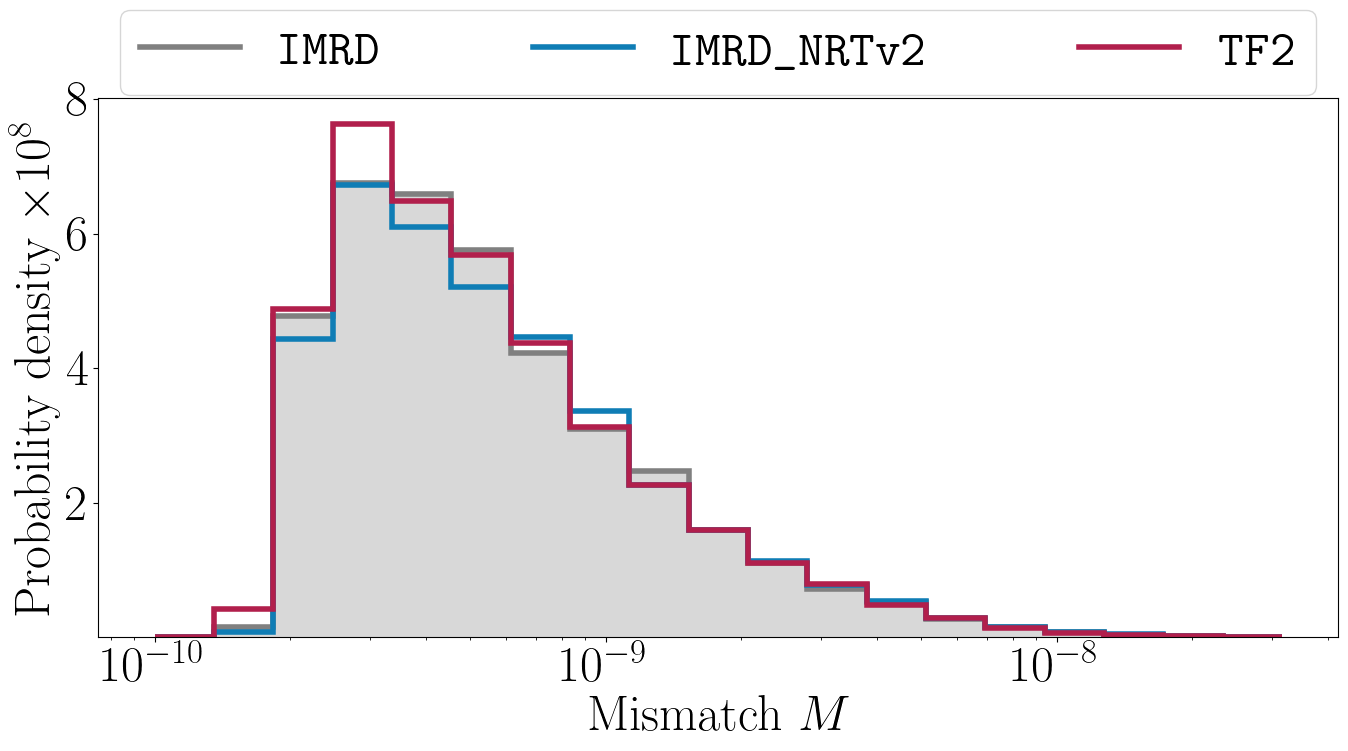

In [5]:
plt.figure(figsize = (16, 7))
lw = 4

N_bins = 20
colors = ["gray", "#0f7db5", "#b11f4c"]
bins = np.logspace(-10, -7.5, N_bins)

for i, (key, value) in enumerate(matches_dict.items()):
    latex_label = approximant_names_latex[i]
    mismatch_values = value["mismatch"]
    mismatch_values = 10 ** mismatch_values
    if i == 0:
        counts, _ = np.histogram(mismatch_values, bins = bins, density=True)
        plt.stairs(counts, bins, fill = True, alpha = 0.3, linewidth=lw, color = colors[i])
    else:
        counts, _ = np.histogram(mismatch_values, bins = bins, density=True)
    plt.stairs(counts, bins, linewidth=lw, label=latex_label, color = colors[i])

plt.xlabel(r"Mismatch $M$")
plt.xscale("log")
# Force tick labels to be a bit nicer
ax = plt.gca()
ax.yaxis.get_offset_text().set_visible(False)
custom_tick_values = [2e8, 4e8, 6e8, 8e8]
custom_tick_labels = ['2', '4', '6', '8']
ax.set_yticks(custom_tick_values)
ax.set_yticklabels(custom_tick_labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.21), ncol=3, columnspacing=3.0)
plt.ylabel(r"Probability density $\times 10^8$")
plt.savefig("../figures/mismatch_histogram.pdf", bbox_inches="tight")
# plt.savefig(public_html + "mismatch_histogram.pdf", bbox_inches="tight")
plt.show()

### Sanity check: without enforcing the bins to be the same

Checking that there is no weird plotting artefact coming from the fact that we use `stairs` instead of `hist`:

In [6]:
# plt.figure(figsize = (10, 6))
# counter = 0
# for key, value in matches_dict.items():
#     latex_label = approximant_names_latex[counter]
#     mismatch_values = value["mismatch"]
#     plt.hist(mismatch_values, bins=50, histtype='step', linewidth=3, density=True, label=latex_label)
#     # plt.hist(mismatch_values, bins=50, histtype='step', linewidth=3, density=True, label=latex_label)
    
#     counter += 1

# plt.xlabel(r"Mismatch $\log_{10} \mathcal{M}$")
# plt.legend()
# plt.ylabel("Density")
# # plt.savefig("../figures/mismatch_histogram.pdf", bbox_inches="tight")
# plt.show()

## Extra: check sampled parameters

In [7]:
matches_filename = os.path.join(os.getcwd(), f"../data/matches_data/matches_IMRPhenomD.csv")
print(f"Waveform: {matches_filename}")
matches_df = pd.read_csv(matches_filename)
matches_df

Waveform: /home/thibeau.wouters/TurboPE-BNS/postprocessing/../data/matches_data/matches_IMRPhenomD.csv


,Unnamed: 0,m1,m2,chi1,chi2,dist_mpc,tc,phi_ref,inclination,match,mismatch
0,9670,0.535438,0.509232,0.012217,-0.032099,151.894148,0.0,5.085573,5.307767,1.0,-7.247322
1,3442,0.542436,0.504080,-0.048880,0.049068,185.053959,0.0,5.405797,0.617663,1.0,-7.249229
2,1178,0.535821,0.511517,0.023541,0.012817,7.335649,0.0,0.854526,5.807647,1.0,-7.251008
3,5511,0.548109,0.506388,-0.031174,-0.014371,149.911915,0.0,5.870885,4.855518,1.0,-7.260033
4,4242,0.560287,0.509798,0.037264,0.032987,69.869572,0.0,5.626959,1.680757,1.0,-7.280456
...,...,...,...,...,...,...,...,...,...,...,...
9995,5297,2.974216,2.943105,0.005541,0.003249,23.355023,0.0,4.530159,2.780408,1.0,-9.742637
9996,8620,2.990553,2.932752,0.018838,-0.039968,77.194174,0.0,2.217766,6.091735,1.0,-9.744246
9997,3389,2.985492,2.945532,-0.018324,0.022030,172.806373,0.0,0.057565,2.565173,1.0,-9.745989
9998,7363,2.998163,2.970778,-0.047160,-0.042095,205.495331,0.0,4.289616,4.970471,1.0,-9.755858


In [8]:
matches_filename = os.path.join(os.getcwd(), f"../data/matches_data/matches_IMRPhenomD_NRTidalv2.csv")
print(f"Waveform: {matches_filename}")
matches_df = pd.read_csv(matches_filename)
matches_df

Waveform: /home/thibeau.wouters/TurboPE-BNS/postprocessing/../data/matches_data/matches_IMRPhenomD_NRTidalv2.csv


,Unnamed: 0,m1,m2,chi1,chi2,lambda1,lambda2,dist_mpc,tc,phi_ref,inclination,match,mismatch
0,8691,0.514558,0.514318,-0.022078,-0.006537,366.091590,4129.805525,79.832696,0.0,1.282352,4.633354,1.0,-7.225946
1,2650,0.551756,0.522497,-0.042121,-0.032088,2142.797271,3528.762238,196.618808,0.0,5.771961,4.936378,1.0,-7.287546
2,6322,0.563528,0.526518,-0.041701,-0.028227,506.262786,651.622646,167.304463,0.0,5.060546,1.277025,1.0,-7.308192
3,2634,0.549288,0.542833,-0.048302,0.014515,4168.929383,2447.825899,275.507344,0.0,4.142646,4.639081,1.0,-7.311878
4,1647,0.574953,0.521497,0.048206,0.038373,3442.362212,1759.819576,2.242796,0.0,1.776438,0.619487,1.0,-7.315386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8648,2.939653,2.921988,-0.028288,-0.040034,4863.205183,4861.238783,230.006097,0.0,0.652322,3.460204,1.0,-9.734013
9996,7550,2.951376,2.945544,-0.033664,0.019351,2601.777457,1899.871762,101.034957,0.0,0.235811,1.491180,1.0,-9.740341
9997,5496,2.996715,2.910912,-0.030092,0.040615,1978.513656,4254.922451,122.044639,0.0,0.149614,0.348013,1.0,-9.743443
9998,5574,2.987100,2.971650,-0.034628,0.036601,1480.098521,4166.276973,258.794290,0.0,2.279851,5.249544,1.0,-9.755875


In [9]:
matches_filename = os.path.join(os.getcwd(), f"../data/matches_data/matches_TaylorF2.csv")
print(f"Waveform: {matches_filename}")
matches_df = pd.read_csv(matches_filename)
matches_df

Waveform: /home/thibeau.wouters/TurboPE-BNS/postprocessing/../data/matches_data/matches_TaylorF2.csv


,Unnamed: 0,m1,m2,chi1,chi2,lambda1,lambda2,dist_mpc,tc,phi_ref,inclination,match,mismatch
0,8618,0.509398,0.500862,0.004732,-0.018966,4356.756988,4218.442631,31.616285,0.0,3.058629,0.913304,1.0,-7.201435
1,3922,0.580815,0.503602,-0.041197,-0.015772,4641.024265,1637.073526,224.685022,0.0,1.360681,2.024202,1.0,-7.299326
2,2185,0.550736,0.531340,-0.032566,-0.038663,575.590112,1138.581143,279.376710,0.0,6.155645,5.710575,1.0,-7.300333
3,9104,0.586844,0.504309,0.020646,-0.038173,1857.275350,1421.669604,136.574004,0.0,1.314779,4.283359,1.0,-7.307599
4,1636,0.560051,0.544989,0.040860,-0.044736,4117.659324,2998.584728,19.446443,0.0,2.536192,5.713568,1.0,-7.330630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8413,2.982518,2.950773,0.033429,0.024140,2986.677368,4316.686013,198.477270,0.0,4.834584,2.561088,1.0,-9.758877
9996,1967,2.982616,2.954001,0.035762,0.024775,2320.507667,4692.537193,281.304686,0.0,2.580122,3.230418,1.0,-9.759458
9997,582,2.991137,2.948648,-0.024080,-0.041948,3801.730982,3147.028902,183.420390,0.0,6.169776,2.481420,1.0,-9.761188
9998,7569,2.995692,2.961640,-0.021001,-0.035228,1209.633261,4434.169193,274.711594,0.0,0.124576,3.357874,1.0,-9.764414
